## EDA 할 내용
- 이미지 당 단어 개수 분포 
- 전체 단어 길이 분포
- image width, height
- 전체 BBOX 크기 분포
    - 넓이 기준
- 전체 태그 별 분포
    - 언어
    - orientation
    - word tag
    - image tag
- aspect ratio (가로/세로)
   - polygon은 rectify하기

In [3]:
# import shutil

# shutil.unpack_archive('../dataset.zip', '../camper_data', 'zip')

In [ ]:
'''
original code source : https://www.kaggle.com/aidapearson/eda-starter-notebook
'''

In [307]:
import json

icdar_data_root = "../input/data/ICDAR17_Korean/ufo/train.json"
camper_data_root = "../camper_data/annotation.json"

def read_json(filename):
    with Path(filename).open(encoding='utf8') as handle:
        ann = json.load(handle)
    return ann
icdar_data = read_json(icdar_data_root)
camper_data = read_json(camper_data_root)

In [302]:
list(map(float,map(int,camper_data['images']['1632652973952.jpg']['words']['0001']['points'][0])))

[305.0, 366.0]

In [303]:
# debugging
from shapely.geometry import Polygon
def filter_vertices(vertices, labels, ignore_under=0, drop_under=0):
    if drop_under == 0 and ignore_under == 0:
        return vertices, labels

    new_vertices, new_labels = vertices.copy(), labels.copy()

    areas = np.array([Polygon(v.reshape((4, 2))).convex_hull.area for v in vertices])
    labels[areas < ignore_under] = 0

    if drop_under > 0:
        passed = areas >= drop_under
        new_vertices, new_labels = new_vertices[passed], new_labels[passed]

    return new_vertices, new_labels
camper_data_changed = camper_data.copy()
polygon_box_list = []
for img in list(camper_data['images'].keys()):
    image = camper_data_changed['images'][img]
    # if len(image['words']) == 0:
    #     test_nobox_list.append(img)
        
    # if img in no_box_image_list:
    #     camper_data_changed['images'].pop(img)
    #     continue
    vertices, labels = [], []
    for word_info in image['words'].values():
        vertices.append(np.array(word_info['points']).flatten())
        labels.append(int(not word_info['illegibility']))
        
    try:
        vertices, labels = np.array(vertices, dtype=np.float32), np.array(labels, dtype=np.int64)
        vertices, labels = filter_vertices(vertices, labels, ignore_under=10, drop_under=1)
    except:
        polygon_box_list.append(img)
        # camper_data_changed['images'][img]['words'][word]['word_tags'] = camper_data_changed['images'][img]['words'][word].pop('tags')
        # for idx in range(len(camper_data_changed['images'][img]['words'][word]['points'])):
        #     camper_data_changed['images'][img]['words'][word]['points'][idx] = list(map(float,map(int,camper_data_changed['images'][img]['words'][word]['points'][idx])))

In [304]:
len(list(set(polygon_box_list)))

265

In [312]:
no_box_image_list = ['20190608_214923.jpg', '20200709_164515.jpg', '20200711_035400.jpg', 
                '20210914_091031.jpeg', '20210914_091624.jpeg', 
                '20210915_141507.jpeg', '20210915_150130.jpeg']
camper_data_changed = camper_data.copy()
print(len(camper_data['images']))
irregular_nobox_list = []
for img in list(camper_data['images'].keys()):
    # image = camper_data_changed['images'][img]
    # if len(image['words']) == 0:
    #     test_nobox_list.append(img)
        
    if img in no_box_image_list or img in polygon_box_list:
        del camper_data_changed['images'][img]
        continue
    # for word in image['words']:
    #     camper_data_changed['images'][img]['words'][word]['word_tags'] = camper_data_changed['images'][img]['words'][word].pop('tags')
        # for idx in range(len(camper_data_changed['images'][img]['words'][word]['points'])):
        #     camper_data_changed['images'][img]['words'][word]['points'][idx] = list(map(float,map(int,camper_data_changed['images'][img]['words'][word]['points'][idx])))
        
print(len(camper_data_changed['images']))

974
702


In [314]:
974-265-7

702

In [315]:
with open('../camper_data.json', 'w') as f:
    json.dump(camper_data_changed, f)

In [306]:
icdar_data['images'].update(camper_data['images'])
len(icdar_data['images'])


with open('../train_camper+icdar.json', 'w') as f:
    json.dump(icdar_data, f)

1238

## 기존 ICDAR + camper들이 annotate한 data

In [129]:
%matplotlib inline
import glob
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import Image
from collections import Counter
import numpy as np

In [130]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [131]:
def read_json(filename):
    with Path(filename).open(encoding='utf8') as handle:
        ann = json.load(handle)
    return ann

In [132]:
# gt file과 raw image file path를 이용해 데이터를 불러온다. 아래 경로는 예시.
data = read_json("../input/data/ICDAR17_Korean/ufo/train_camper+icdar.json")

In [133]:
def get_box_size(quads):
    """ 단어 영역의 사각형 좌표가 주어졌을 때 가로, 세로길이를 계산해주는 함수.
    TODO: 각 변의 길이를 단순히 max로 처리하기때문에 직사각형에 가까운 형태가 아니면 약간 왜곡이 있다.
    Args:
        quads: np.ndarray(n, 4, 2) n개 단어 bounding-box의 4개 점 좌표 (단위 pixel)
    Return:
        sizes: np.ndarray(n, 2) n개 box의 (height, width)쌍
    """
    dists = []
    for i, j in [(1, 2), (3, 0), (0, 1), (2, 3)]: # [right(height), left(height), upper(width), lower(width)] sides
        dists.append(np.linalg.norm(quads[:, i] - quads[:, j], ord=2, axis=1))

    dists = np.stack(dists, axis=-1).reshape(-1, 2, 2) # shape (n, 2, 2) widths, heights into separate dim
    return np.rint(dists.mean(axis=-1)).astype(int)

In [134]:
def rectify_poly(poly, direction, img_w, img_h):
    """일반 polygon형태인 라벨을 크롭하고 rectify해주는 함수.
    Args:
        poly: np.ndarray(2n+4, 2) (where n>0), 4, 6, 8
        image: np.ndarray opencv 포멧의 이미지
        direction: 글자의 읽는 방향과 진행 방향의 수평(Horizontal) 혹은 수직(Vertical) 여부
    Return:
        rectified: np.ndarray(2, ?) rectify된 단어 bbox의 사이즈.
    """
    
    n_pts = poly.shape[0]
    assert n_pts % 2 == 0
    if n_pts == 4:
        size = get_box_size(poly[None])
        h = size[:, 0] / img_h
        w = size[:, 1] / img_w
        return np.stack((h,w))

    def unroll(indices):
        return list(zip(indices[:-1], indices[1:]))

    # polygon하나를 인접한 사각형 여러개로 쪼갠다.
    indices = list(range(n_pts))
    if direction == 'Horizontal':
        upper_pts = unroll(indices[:n_pts // 2]) # (0, 1), (1, 2), ... (4, 5)
        lower_pts = unroll(indices[n_pts // 2:])[::-1] # (8, 9), (7, 8), ... (6, 7)

        quads = np.stack([poly[[i, j, k, l]] for (i, j), (k, l) in zip(upper_pts, lower_pts)])
    else:
        right_pts = unroll(indices[1:n_pts // 2 + 1]) # (1, 2), (2, 3), ... (4, 5)
        left_pts = unroll([0] + indices[:n_pts // 2:-1]) # (0, 9), (9, 8), ... (7, 6)

        quads = np.stack([poly[[i, j, k, l]] for (j, k), (i, l) in zip(right_pts, left_pts)])

    sizes = get_box_size(quads)
    if direction == 'Horizontal':
        h = sizes[:, 0].max() / img_h
        widths = sizes[:, 1]
        w = np.sum(widths) / img_w
        return np.stack((h,w)).reshape(2,-1)
        #return np.stack((h,w))
    elif direction == 'Vertical':
        heights = sizes[:, 0]
        w = sizes[:, 1].max() / img_w
        h = np.sum(heights) / img_h
        return np.stack((h,w)).reshape(2,-1)
    else:
        h = sizes[:, 0] / img_h
        w = sizes[:, 1] / img_w
        return np.stack((h,w),-1)

In [136]:
df = {}
df['image'] = []
df['word_counts'] = []
df['image_width'] = []
df['image_height'] = []
df['image_tags'] = []
img_tags = []

quads = []
polys = []
seq_length = []
hor_sizes = []
ver_sizes = []
irr_sizes = []
languages = []
orientation = []
word_tags = []
aspect_ratio = []
ver_string = []

for image_key, image_value in data["images"].items():
    df['image'].append(image_key)
    img_w = image_value['img_w']
    img_h = image_value['img_h']
    df['image_width'].append(img_w)
    df['image_height'].append(img_h)
    df['image_tags'].append(image_value['tags'])
    df['image_tags']= [['None'] if v is None else v for v in df['image_tags']] # our data does not inlcude multi-tag images 
    word_ann = image_value['words']
    count_ill = 0 
    for word in word_ann.values():
        if word['illegibility']== False:
            orientation.append(word['orientation'])
            orientation = [v for v in orientation]
            seq_length.append(len(word['transcription']))
            languages.append(word['language'])
            languages = [['None'] if v is None else v for v in languages] # our data does not inlcude multi-language words
            if word['word_tags'] != None:
                word_tags.extend(word['word_tags'][:])
            elif word['word_tags']== None:
                word_tags.append('None')
            poly = np.int32(word['points'])
            size = rectify_poly(poly, word['orientation'], img_w, img_h)
            if word['orientation'] == 'Horizontal':
                hor_sizes.append(size)
            elif word['orientation'] == 'Vertical':
                ver_sizes.append(size)
            else:
                irr_sizes.append(size)
            
        else:
            count_ill += 1
    df['word_counts'].append(len(word_ann)-count_ill)

        
all_sizes = hor_sizes + ver_sizes + irr_sizes
quad_area = [all_sizes[i][0]*all_sizes[i][1] for i in range(len(all_sizes))]
total_area = []
for s in quad_area:
    if s.shape[0] == 1:
        total_area.append(np.sum(s[0])) 
    else:
        total_area.append(np.sum(s))

hor_aspect_ratio = [hor_sizes[i][1]/hor_sizes[i][0] for i in range(len(hor_sizes))]
ver_aspect_ratio = [ver_sizes[i][1]/ver_sizes[i][0] for i in range(len(ver_sizes))]

image_df = pd.DataFrame.from_dict(df)

In [137]:
new_image_tags = []
for i, row in image_df.iterrows():
    if len(row['image_tags']) == 0:
        new_image_tags.append(['None'])
    else:
        new_image_tags.append(row['image_tags'])
image_df['image_tags'] = new_image_tags

In [138]:
image_df['image_tags'] = image_df['image_tags'].apply(lambda x: ','.join(map(str, x)))
image_df

,image,word_counts,image_width,image_height,image_tags
0,img_4380.jpg,3,1836,2448,None
1,img_4583.jpg,2,2268,2268,None
2,img_4234.jpg,7,2592,3456,None
3,img_4345.jpg,7,1836,2448,None
4,img_4016.jpg,1,1836,2448,None
...,...,...,...,...,...
1505,1632655308620-22.jpg,11,467,960,None
1506,1632655308620-25.jpg,27,1080,2220,None
1507,1632655330045-21.jpg,3,1334,1334,None
1508,1632655330045-23.jpg,2,467,960,None


In [139]:
image_df['image_tags'].describe()

count     1510
unique       8
top       None
freq      1429
Name: image_tags, dtype: object

In [140]:
image_df['image_tags'].value_counts()

None                    1429
handwriting               25
outfocus                  24
document                  14
noisy                     14
noisy,outfocus             2
handwriting,note           1
handwriting,outfocus       1
Name: image_tags, dtype: int64

In [141]:
# check if there are image with multiple image tags (which would apper as e.g. "document, outfocus")
set(image_df['image_tags'].tolist())

{'None',
 'document',
 'handwriting',
 'handwriting,note',
 'handwriting,outfocus',
 'noisy',
 'noisy,outfocus',
 'outfocus'}

In [142]:
image_df.describe()

,word_counts,image_width,image_height
count,1510.000000,1510.000000,1510.000000
mean,16.417881,2864.386093,2981.343709
std,28.465753,986.315138,1081.069312
min,0.000000,409.000000,351.000000
25%,3.000000,2328.000000,2268.000000
50%,8.000000,3024.000000,3024.000000
75%,17.000000,3120.000000,4032.000000
max,578.000000,9248.000000,9248.000000


In [143]:
# just for checking
list(data['images'].keys())[0]

'img_4380.jpg'

In [144]:
first_img = list(data['images'].keys())[0]
data["images"][first_img].keys()

dict_keys(['img_h', 'img_w', 'words', 'tags', 'license_tag'])

/opt/conda/envs/competition/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


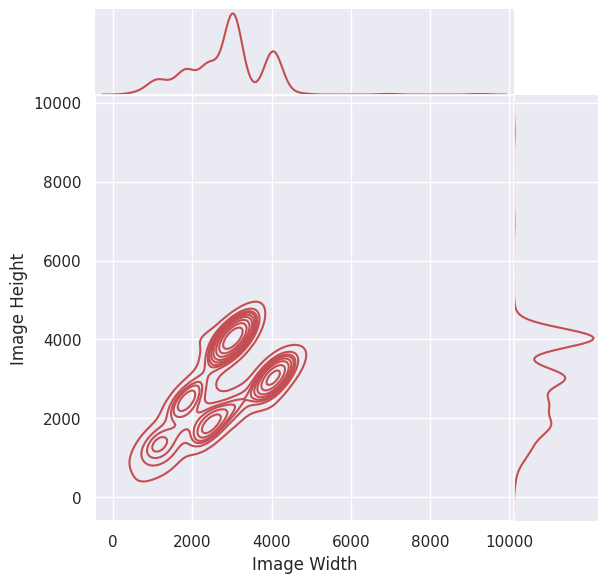

In [145]:
# image width, height 
g = sns.jointplot("image_width", "image_height", data=image_df, kind="kde", space=0, color="r")
g.set_axis_labels("Image Width", "Image Height")

In [146]:
def create_count_df(df, field, index):
    count=df.groupby(field)[index].count().sort_values(ascending=False)
    count_df = count.to_frame().reset_index()
    count_df.columns = [field, field + '_count']
    return count_df

def plot_count_df(df, field, random_sample, color, rotation, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(10,6))
    if random_sample:
        df = df.sample(n=50, random_state=1)
    bars = ax.bar(df[field], df[field + '_count'], color=color, align='center',alpha=0.5)
    for i, b in enumerate(bars):
        ax.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.1, \
                df.iloc[i][field + '_count'],ha='center',fontsize=13)
    ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()
    

/tmp/ipykernel_2115/2687934052.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)


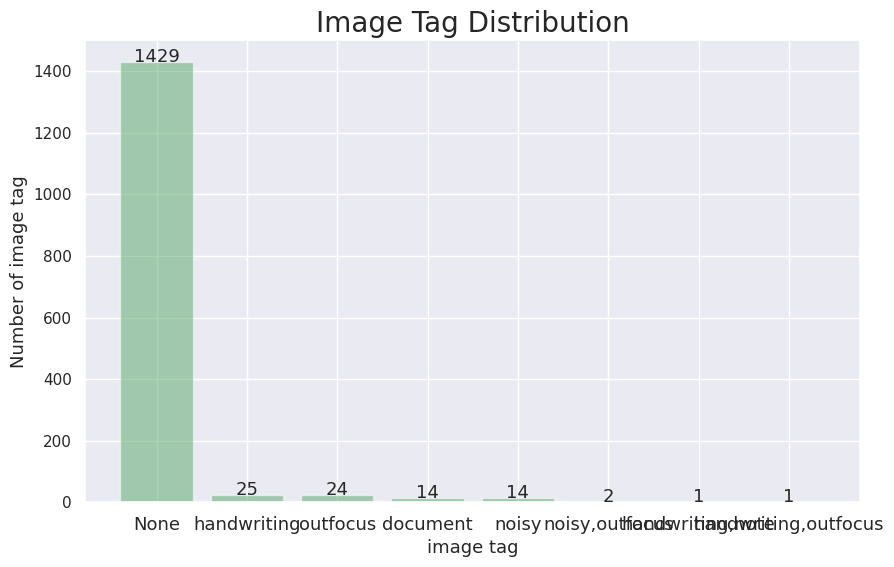

In [147]:
img_tag_df = create_count_df(df=image_df, field='image_tags', index='image')
plot_count_df(df=img_tag_df, field='image_tags', random_sample=False, color='g', rotation=0, xlabel='image tag', \
              ylabel='Number of image tag', title='Image Tag Distribution')

In [171]:
df = pd.DataFrame(word_tags, columns = ['word_tags'])
df['word_tags'].value_counts()

None             3608
segmented        1236
handwriting      1141
embossing         545
occlusion         493
logo              327
mirrored          109
stamp              14
strikethrough       8
Name: word_tags, dtype: int64

In [172]:
df.shape

(7481, 1)

/tmp/ipykernel_2115/2687934052.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)


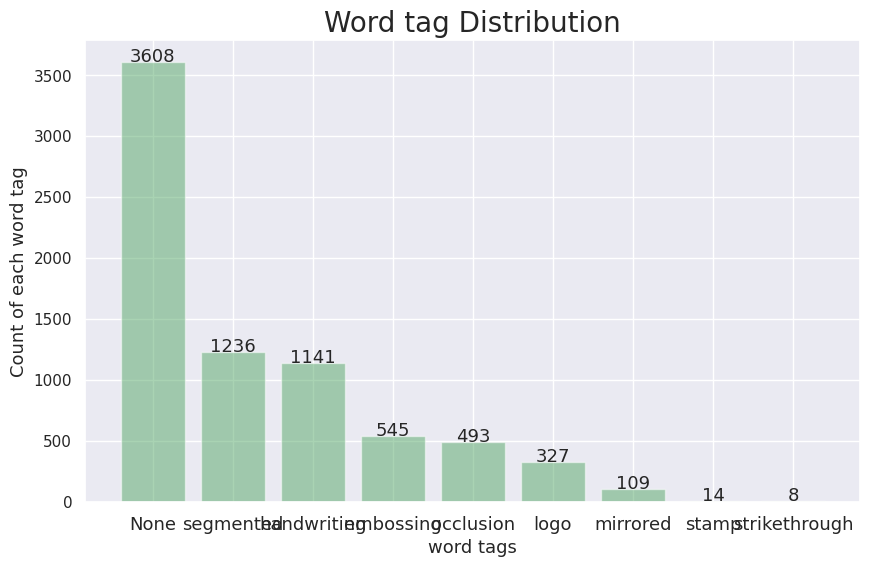

In [148]:
# Total word tags 
word_tag_df = pd.DataFrame(word_tags, columns = ['word_tags'])
word_tag_df['index'] = [i for i in range(len(word_tags))]
word_tag_df = create_count_df(word_tag_df, field='word_tags',index='index')
plot_count_df(df=word_tag_df, field='word_tags', random_sample=False, color='g', rotation=0, xlabel='word tags', \
              ylabel='Count of each word tag', title='Word tag Distribution')

In [149]:
word_tag_df['word_tags'].unique()

array(['None', 'segmented', 'handwriting', 'embossing', 'occlusion',
       'logo', 'mirrored', 'stamp', 'strikethrough'], dtype=object)

In [173]:
# word_tag_df.iloc[0]['word_tags_count']

3608

In [151]:
def plot_dist(df, field, bins, color, xlabel, ylabel, title):
    sns.set(color_codes=True)
    fig, ax = plt.subplots(figsize=(18,6))
    sns.distplot(df[field], bins=bins, color=color, ax=ax)
    
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()

/opt/conda/envs/competition/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


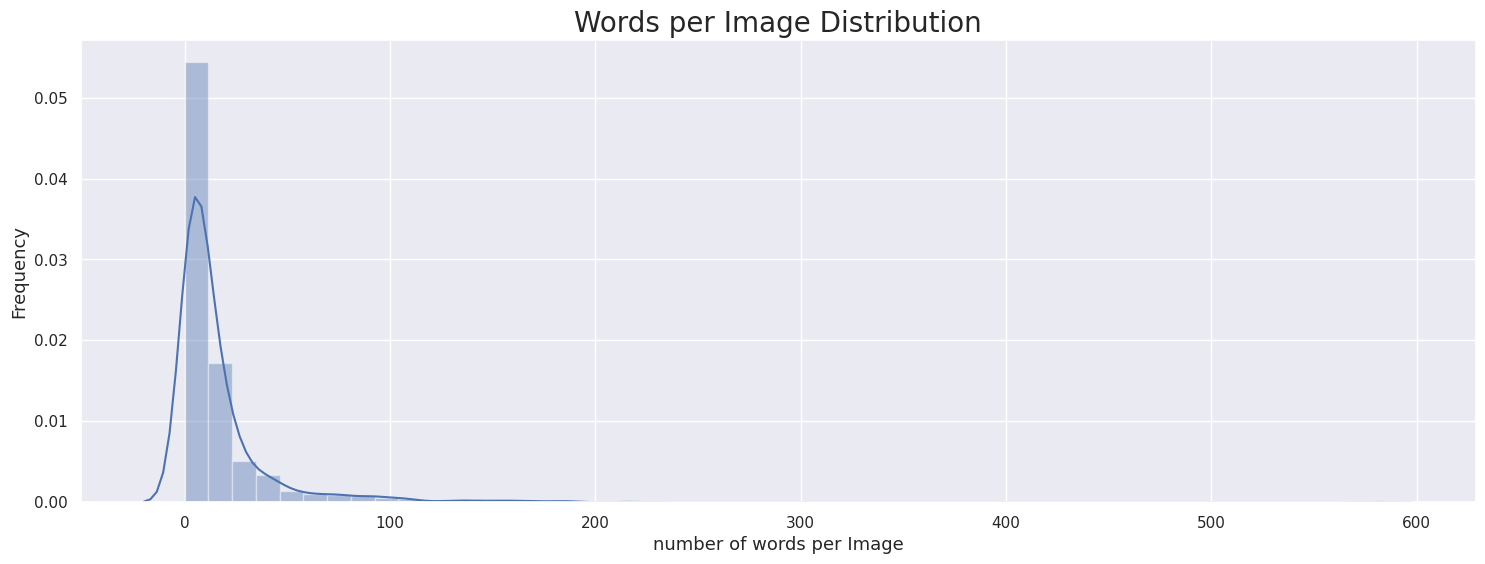

In [152]:
plot_dist(df=image_df, field='word_counts', bins=50, color='b', xlabel='number of words per Image', \
          ylabel='Frequency', title='Words per Image Distribution')

In [153]:
word_df ={}
word_df['index'] = [i for i in range(len(total_area))]
word_df['orientation'] = orientation
word_df['language'] = languages
word_df['bbox_size'] = total_area

In [154]:
word_df = pd.DataFrame.from_dict(word_df)

In [155]:
word_df['language'] = word_df['language'].apply(lambda x: ','.join(map(str, x)))
word_df

,index,orientation,language,bbox_size
0,0,Horizontal,ko,0.048589
1,1,Horizontal,ko,0.025967
2,2,Horizontal,ko,0.031213
3,3,Horizontal,en,0.057850
4,4,Horizontal,ko,0.062125
...,...,...,...,...
24786,24786,Horizontal,ko,0.018938
24787,24787,Horizontal,ko,0.000587
24788,24788,Horizontal,ko,0.004326
24789,24789,Horizontal,ko,0.000269


In [156]:
word_df.describe()['bbox_size']

count    24791.000000
mean         0.006970
std          0.022804
min          0.000004
25%          0.000297
50%          0.000918
75%          0.003625
max          0.815827
Name: bbox_size, dtype: float64

In [157]:
word_df.columns

Index(['index', 'orientation', 'language', 'bbox_size'], dtype='object')

/tmp/ipykernel_2115/2687934052.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)


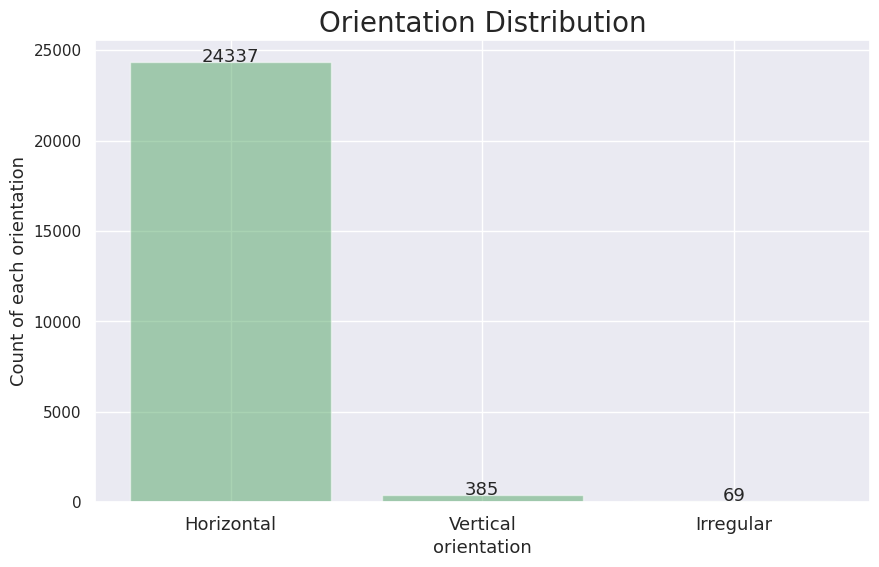

In [158]:
orientation = create_count_df(df=word_df, field='orientation', index='index')
plot_count_df(df=orientation, field='orientation', random_sample=False, color='g', rotation=0, xlabel='orientation', \
              ylabel='Count of each orientation', title='Orientation Distribution')

In [159]:
orientation

,orientation,orientation_count
0,Horizontal,24337
1,Vertical,385
2,Irregular,69


/tmp/ipykernel_2115/2687934052.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)


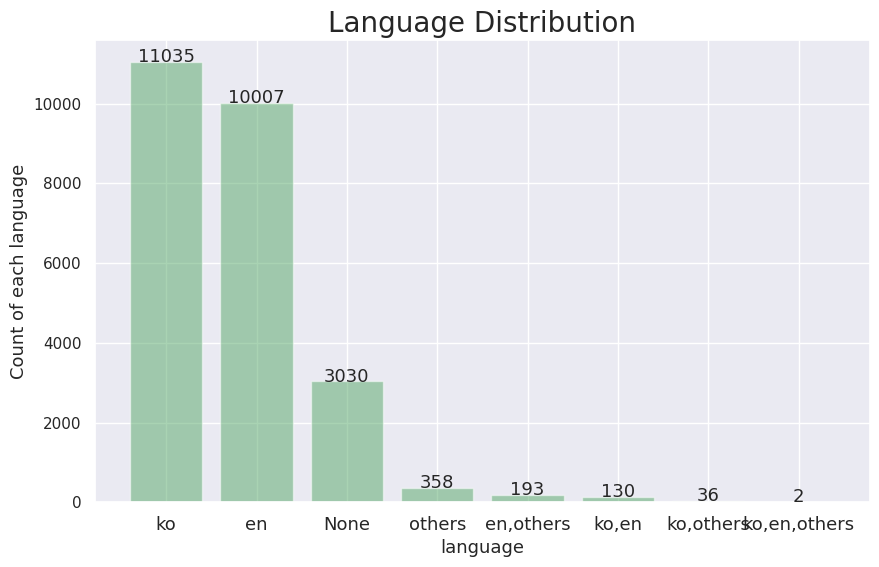

In [160]:
# None means it's either a different language or a special symbol
lang = create_count_df(df=word_df, field='language', index='index')
plot_count_df(df=lang, field='language', random_sample=False, color='g', rotation=0, xlabel='language', \
              ylabel='Count of each language', title='Language Distribution')

In [161]:
# print(f'ko: {2800/3608*100}%, en: {808/3608*100}%')

/opt/conda/envs/competition/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


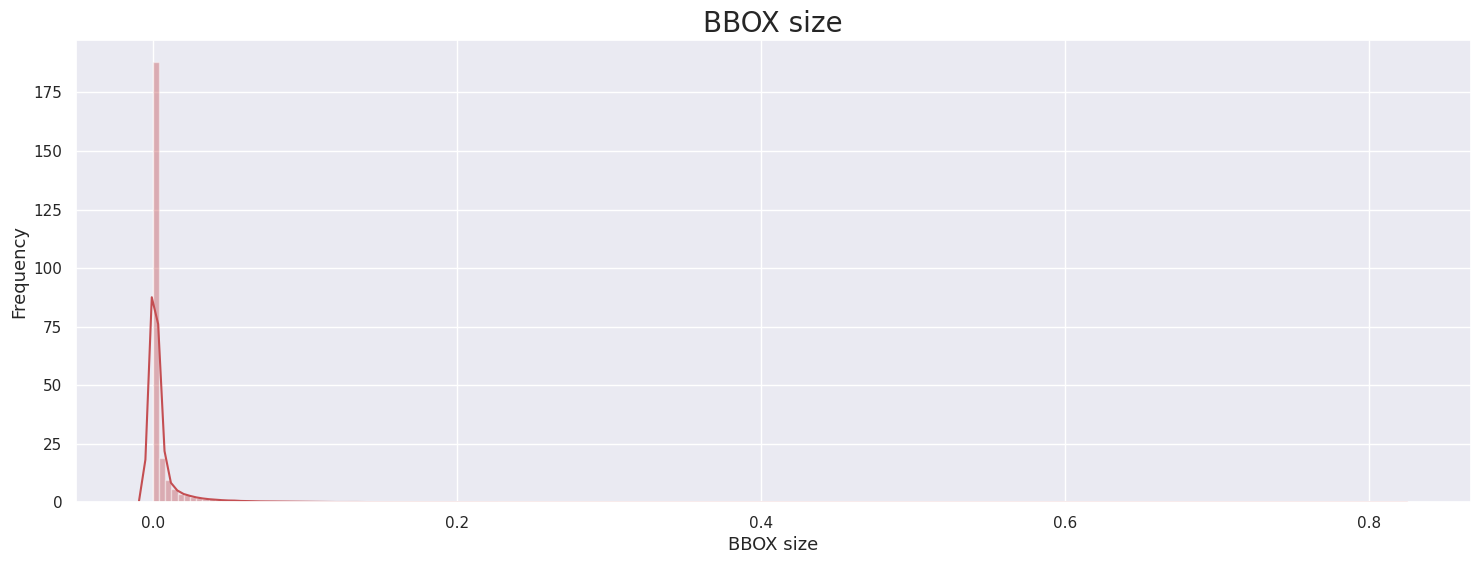

In [162]:
plot_dist(df=word_df, field='bbox_size', bins=200, color='r', xlabel='BBOX size', \
          ylabel='Frequency', title='BBOX size')

In [163]:
def plot_dist_list(target_list, bins, color, xlabel, ylabel, title):
    sns.set(color_codes=True)
    fig, ax = plt.subplots(figsize=(18,6))
    sns.distplot(target_list, bins=bins, color=color, ax=ax)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()

In [164]:
pd.DataFrame(ver_aspect_ratio, columns=['aspect ratio']).describe()

,aspect ratio
count,385.000000
mean,0.800722
std,1.626851
min,0.081590
25%,0.250301
50%,0.391175
75%,0.569892
max,19.111111


In [176]:
pd.DataFrame(hor_aspect_ratio, columns=['aspect ratio']).describe()

,aspect ratio
count,24337.000000
mean,3.019963
std,2.719178
min,0.051926
25%,1.417989
50%,2.461538
75%,3.934959
max,133.166667


/opt/conda/envs/competition/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


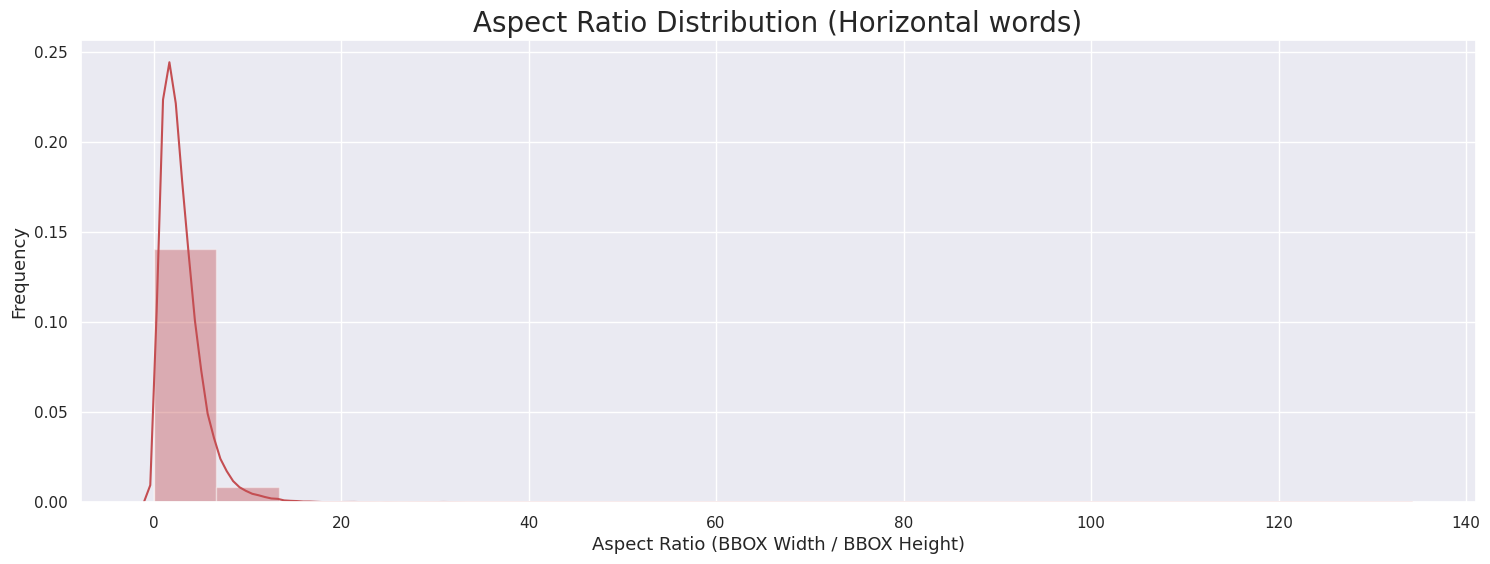

In [165]:
# 한 두글자짜리 단어나 숫자의 경우 aspect ratio가 1미만인 경우가 있다
plot_dist_list(hor_aspect_ratio, bins=20, color='r', xlabel='Aspect Ratio (BBOX Width / BBOX Height)', \
          ylabel='Frequency', title='Aspect Ratio Distribution (Horizontal words)')

/opt/conda/envs/competition/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


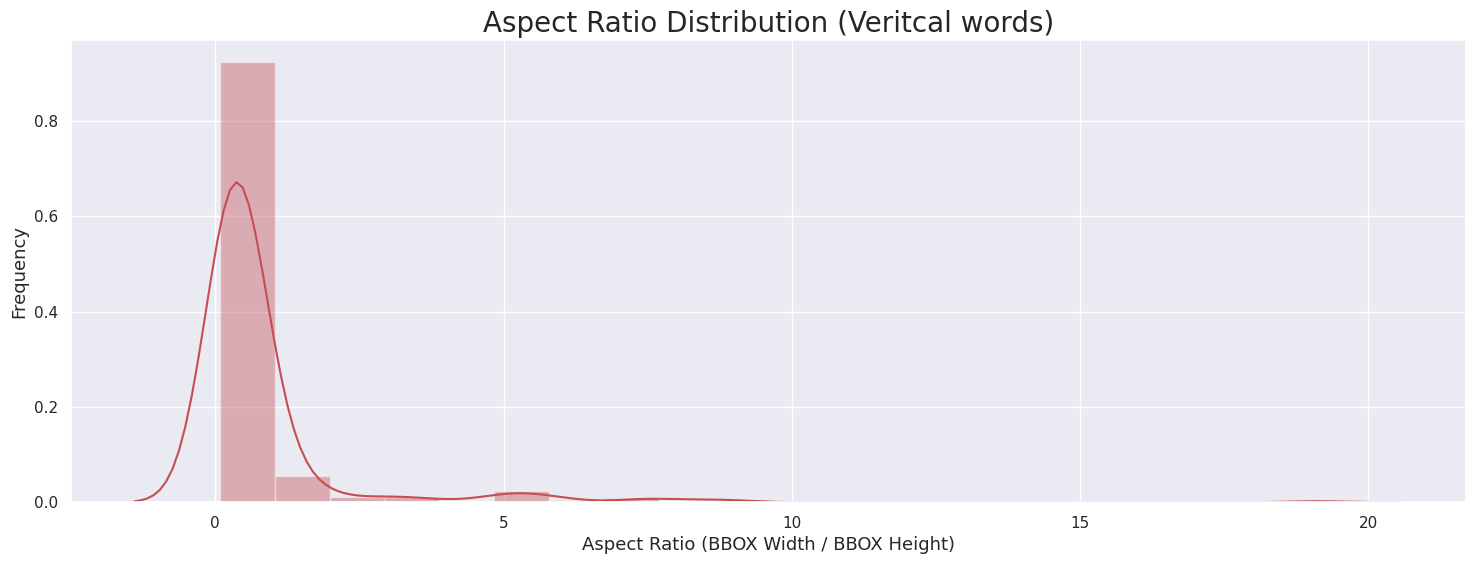

In [166]:
# aspect ratio가 1.88정도 되는 경우가 하나 있음. 이미지에서 글자가 왜곡되어 있었고 박스가 약간 널널하게 잡힌 케이스. 
plot_dist_list(ver_aspect_ratio, bins=20, color='r', xlabel='Aspect Ratio (BBOX Width / BBOX Height)', \
          ylabel='Frequency', title='Aspect Ratio Distribution (Veritcal words)')